In [1]:
!pip3 install pybullet --upgrade --user

Requirement already up-to-date: pybullet in /Users/user/.local/lib/python3.7/site-packages (3.1.7)
You should consider upgrading via the '/Users/user/anaconda3/envs/pwil/bin/python -m pip install --upgrade pip' command.


In [1]:
import torch
import gym
import argparse
import os
import pickle
import numpy as np
import random
import torch.optim as optim
import torch_optimizer as th_optim
import pybullet_envs

from torch.utils.data import DataLoader, ConcatDataset
from torch.distributions import Normal
from models import *
from utils import *
from dataset import *

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_simple_bco(records, records2=None, env_name=None, s=100, off=0.8):
    ypoints = np.array(records)
    plt.plot(ypoints)
    if records2 is not None:
        ypoints = np.array(records2)
        plt.plot(ypoints, linestyle = 'dotted')
    else:
        ypoints[1:] = ypoints[1:] #- (np.random.rand(ypoints[1:].shape[0])-0.25)*2*s + (np.random.rand(ypoints[1:].shape[0])-off)*4*s
    plt.title(env_name)
    plt.xlabel('steps (10e3)')
    plt.ylabel('reward')
    plt.legend(["Forward matching", "BC from observation"], loc ="lower right")
    plt.show()

In [3]:
def add_noise_to_weights(model):
    print('add noise to weight')
    with torch.no_grad():
        for param in model.parameters():
            param.add_(torch.randn(param.size()) * 0.1)
            
class NNet(nn.Module):
    def __init__(self, D_in, D_out, 
                 n_hidden=64,
                 do_rate=0.1,
                 activation_in='relu'):
        super(NNet, self).__init__()
        if activation_in == 'relu':
            mid_act = torch.nn.ReLU()
        elif activation_in == 'tanh':
            mid_act = torch.nn.Tanh()
        elif activation_in == 'sigmoid':
            mid_act = torch.nn.Sigmoid()

        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(D_in, n_hidden),
            mid_act,
            torch.nn.Linear(n_hidden, n_hidden),
            #torch.nn.Dropout(0.1),
            mid_act,

            torch.nn.Linear(n_hidden, n_hidden),
            #torch.nn.Dropout(0.1),
            mid_act,

            #torch.nn.utils.spectral_norm(torch.nn.Linear(n_hidden, D_out, bias=True)),
            torch.nn.Linear(n_hidden, D_out, bias=True),
            #torch.nn.Dropout(0.1),
        )

    def forward(self, s, a):
        x = torch.cat((s,a), dim=1)
        x = self.model(x)
        return x
    

class EnsembleModels(object):
    
    def __init__(self, n_ensemble=5,
                reg='free',
                n_hidden=64,
                activation_in='relu',
                state_dim=1,
                action_dim=1):
        super(EnsembleModels, self).__init__()
        self.n_ensemble = n_ensemble
        self.reg = reg
        self.n_hidden = n_hidden
        self.activation_in = activation_in
        self.state_dim = state_dim
        self.action_dim = action_dim

        # create the NNs
        self.NNs=[]
        for m in range(self.n_ensemble):
            self.NNs.append(self.fn_make_simple_NN(activation_in=self.activation_in))
            #NNs.append(fn_make_NN(activation_in=activation_in))

    def fn_make_simple_NN(self, activation_in='relu'):
        s_dim, a_dim = self.state_dim, self.action_dim # input and output dimension
        
        model = NNet(self.state_dim+self.action_dim,
                     self.state_dim,
                     n_hidden=self.n_hidden,
                     activation_in=self.activation_in)
        return model

    def fn_predict_ensemble(self, x_test):
        ''' fn to predict given a list of NNs (an ensemble)''' 
        y_preds = []
        for m in range(self.n_ensemble):
            y_preds.append(self.NNs[m](torch.tensor(x_test).float()).data.numpy())
        y_preds = np.array(y_preds)

        y_preds_mu = np.mean(y_preds,axis=0)
        y_preds_std = np.std(y_preds,axis=0)

        return y_preds, y_preds_mu, y_preds_std

In [20]:
def inv_model_training(transitions, inv_model, ep_num=100):
    inv_dataset = transition_dataset(transitions)
    #inv_dataset_list.append(inv_dataset)
    #inv_dataset_final = ConcatDataset(inv_dataset_list)
    inv_loader = DataLoader(inv_dataset, batch_size=1024, shuffle=True, num_workers=4)

    for m in range(inv_model.n_ensemble):
        print('-- training: ' + str(m+1) + ' of ' + str(inv_model.n_ensemble) + ' NNs --')
        add_noise_to_weights(inv_model.NNs[m])

        #inv_opt = optim.Adam(inv_model.parameters(), lr=1e-3, weight_decay=0.0001)
        #"""
        inv_opt_yogi = th_optim.Yogi(
            inv_model.NNs[m].parameters(),
            lr= 1e-2,
            betas=(0.9, 0.999),
            eps=1e-3,
            initial_accumulator=1e-6,
            weight_decay=0,
        )

        inv_opt = th_optim.Lookahead(inv_opt_yogi,  alpha=0.5)#k=5
        #"""
        inv_loss = nn.MSELoss()

        for epoch in range(ep_num): 
            running_loss = 0
            for i, data in enumerate(inv_loader):
                s, a, s_prime = data
                inv_opt.zero_grad()
                
                pred = inv_model.NNs[m](s.float(), a.float())
                loss = inv_loss(pred, s_prime.float())
               
                loss.backward()
                running_loss += loss.item()
                if i%100 == 99:
                    running_loss = 0
                inv_opt.step()
            if epoch%20==0:
                print('Epoch:%d Batch:%d Loss:%.5f'%(epoch, i+1, loss))
        print('Done!')
    return inv_model

def train_bc(trajs, policy, dynamics,  ep_num=50, sample_itr=500):
    
    bc_dataset = imitation_dataset(trajs)
    bc_loader = DataLoader(bc_dataset, batch_size=1024, shuffle=True, num_workers=4)
    add_noise_to_weights(policy)
    
    print('Learning policy....')
    #bc_opt = optim.Adam(policy.parameters(), lr=1e-3, weight_decay=0.0001)
    #"""
    bc_opt_yogi = th_optim.Yogi(
        policy.parameters(),
        lr= 1e-2,
        betas=(0.9, 0.999),
        eps=1e-3,
        initial_accumulator=1e-6,
        weight_decay=0,
    )

    bc_opt = th_optim.Lookahead(bc_opt_yogi,  alpha=0.5)#k=5,
    #"""
    bc_loss = nn.MSELoss()
    # bc_loss = nn.L1Loss()

    for epoch in range(ep_num):  
        running_loss = 0
        for i, data in enumerate(bc_loader):
            s, s_prime = data
            bc_opt.zero_grad()
            
            #"""
            #a_pred = policy.reparam_forward(s.float())
            try:
                a_mu, a_sigma = policy(s.float())
                a_pred = Normal(loc=a_mu, scale=a_sigma).rsample()
            except:
                a_pred = policy.reparam_forward(s.float())
            #"""
            #print(torch.cat((s, a_pred), dim=1).shape)
            
            loss = 0
            for m in range(dynamics.n_ensemble):
                preds = dynamics.NNs[m](s, a_pred) 
                loss += bc_loss(preds, s_prime)
         
            running_loss += loss.item()
            loss.backward()
            if i%20 == 19:
                running_loss = 0
            bc_opt.step()
        if epoch%10==0:
            print('Epoch:%d Batch:%d Loss:%.3f'%(epoch, i+1, loss))

    print('Done!')
    return policy


def load_demos(DEMO_DIR):
    """load demonstrations"""
    try:
        trajstrajs = np.load("experts/states_expert_walker_.npy")[:10]
    except:
        with open(DEMO_DIR, 'rb') as f:
            trajs = pickle.load(f)
    demos = []
    for t_id, traj in enumerate(trajs):
        demo =[]
        #print(t_id)
        for item in traj:    
            obs = item['observation']
            #obs = list(obs)
            #print(obs)
            demo.append(obs)
        #print(np.array(demo).shape)
        demos.append(np.array(demo))

    print(np.array(demos).shape)
    demos = demos[:10]
    return demos

In [21]:
env_list = ["Pendulum-v0", "BipedalWalker-v3", "Walker2DBulletEnv-v0", "HopperBulletEnv-v0", "HalfCheetahBulletEnv-v0", "AntBulletEnv-v0", "HumanoidBulletEnv-v0"]

runs = 20
inv_samples = 1000
max_steps = 800
expert_path='experts/'
weight_path="weights/"
        
test_rewards_envs = []
record_folder = "records/forward/"
init_seeds = [0,2,4,5]
itr_per_env = len(init_seeds)

for itr_id in range(itr_per_env):
    seed = init_seeds[itr_id]
    for en in env_list[1:]:
        print("############# start "+en+" training ###################")

        ENV_NAME = en#env_list[3]
        env=ENV_NAME
        
        DEMO_DIR = os.path.join(expert_path, env+'.pkl')
        M = inv_samples

        record_fn = record_folder + ENV_NAME + str(itr_id) + ".txt"

        """load demonstrations"""
        demos = load_demos(DEMO_DIR)

        """create environments"""
        env = gym.make(ENV_NAME)
        obs_dim, act_dim = env.observation_space.shape[0], env.action_space.shape[0]

        """init random seeds for reproduction"""
        torch.manual_seed(seed)
        env.seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        env.action_space.seed(seed)

        """init models"""
        #policy = policy_multinomial(env.observation_space.shape[0],64,env.action_space.shape[0], n_heads=15, do_rate=0.04)#.cuda()
        #policy = MDN(obs_dim, out_features=act_dim, n_hidden=64,  num_gaussians=3)
        policy = policy_continuous(env.observation_space.shape[0],64,env.action_space.shape[0], uncertain=True)#.cuda()
        #inv_model = MDN(in_features=obs_dim+act_dim, out_features=obs_dim, n_hidden=32,  num_gaussians=10)
        #inv_model = forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True, do_rate=0.08)#.cuda()
        #inv_model = policy_multinomial(obs_dim+act_dim,100,obs_dim, n_heads=15)#.cuda()
        inv_model = EnsembleModels(n_ensemble=5,
                                    reg='free',
                                    n_hidden=64,
                                    activation_in='relu',
                                    state_dim=env.observation_space.shape[0],
                                    action_dim=env.action_space.shape[0],)
        
        inv_model_best = None
        reward_best = -1000

        inv_dataset_list = []
        use_policy = False

        transitions = []
        test_rewards = []
        for steps in range(runs):
            print('######## STEP %d #######'%(steps+1))
            ### GET SAMPLES FOR LEARNING INVERSE MODEL
            print('Collecting transitions for learning inverse model....')
            if steps > 0:
                use_policy = True


            trans_samples, avg_reward = gen_inv_samples(env, policy.cpu(), M, 'continuous', use_policy, max_steps=max_steps)
            transitions = transitions+trans_samples

            f = open(record_fn, "a+")
            f.write(str(avg_reward) + "\n")
            f.close()

            """
            if len(transitions) > 92000:
                transitions = random.sample(transitions,92000)
            """
            test_rewards.append(avg_reward)
            print('Done!', np.array(transitions).shape)

            ### LEARN THE INVERSE MODEL
            #inv_model = policy_multinomial(obs_dim+act_dim,100,obs_dim, n_heads=15)#.cuda()
            #inv_model = forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True, do_rate=0.08)#.cuda()
            #inv_model = MDN(in_features=obs_dim+act_dim, out_features=obs_dim, n_hidden=32,  num_gaussians=10)#forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True)#.cuda()

            print('Learning dynamic model....')
            inv_model = inv_model_training(transitions, inv_model,  ep_num=150)

            ### GET ACTIONS FOR DEMOS
            #inv_model.cpu()
            print('Getting labels for demos....')
            trajs = get_state_labels(demos)
            print('Done!')


            ### PERFORM BEHAVIORAL CLONING
            policy = train_bc(trajs, policy, inv_model, ep_num=100)

        torch.save(policy, weight_path+ENV_NAME+str(itr_id)+'.pt')
        test_rewards_envs.append(test_rewards)

############# start BipedalWalker-v3 training ###################


/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(49,)
######## STEP 1 #######
reward: -103.19613867788638 setps: 100 count: 100
reward: -104.89378569665428 setps: 60 count: 160
reward: -102.36979020965472 setps: 111 count: 271
reward: -122.54565536505669 setps: 115 count: 386
reward: -25.910537060926504 setps: 613 count: 999
avg rewards: -91.78318140203571
Done! (1000, 3)
Learning dynamic model....
-- training: 1 of 5 NNs --
add noise to weight
Done!
-- training: 2 of 5 NNs --
add noise to weight
Done!
-- training: 3 of 5 NNs --
add noise to weight
Done!
-- training: 4 of 5 NNs --
add noise to weight
Done!
-- training: 5 of 5 NNs --
add noise to weight
Done!
Getting labels for demos....
Done!
add noise to weight
Learning policy....


/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


AttributeError: 'policy_continuous' object has no attribute 'reparam_forward'

In [ ]:
env_list = ["Pendulum-v0", "BipedalWalker-v3", "Walker2DBulletEnv-v0", "HopperBulletEnv-v0", "HalfCheetahBulletEnv-v0", "AntBulletEnv-v0", "HumanoidBulletEnv-v0"]

runs = 50
inv_samples = 1000
max_steps = 1000
expert_path='experts/'
weight_path="weights/"
        
test_rewards_envs = []
record_folder = "records/forward/"
init_seeds = [0,2,4,5]
itr_per_env = len(init_seeds)

for itr_id in range(itr_per_env):
    seed = init_seeds[itr_id]
    for en in env_list[1:]:
        print("############# start "+en+" training ###################")

        ENV_NAME = en#env_list[3]
        env=ENV_NAME
        
        DEMO_DIR = os.path.join(expert_path, env+'.pkl')
        M = inv_samples

        record_fn = record_folder + ENV_NAME + str(itr_id) + ".txt"

        """load demonstrations"""
        demos = load_demos(DEMO_DIR)

        """create environments"""
        env = gym.make(ENV_NAME)
        obs_dim, act_dim = env.observation_space.shape[0], env.action_space.shape[0]

        """init random seeds for reproduction"""
        torch.manual_seed(seed)
        env.seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        env.action_space.seed(seed)

        """init models"""
        policy = policy_multinomial(env.observation_space.shape[0],64,env.action_space.shape[0], n_heads=10, do_rate=0.01)#.cuda()
        
        #policy = MDN(obs_dim, out_features=act_dim, n_hidden=64,  num_gaussians=3)
        #policy = policy_continuous(env.observation_space.shape[0],64,env.action_space.shape[0], uncertain=True)#.cuda()
        #inv_model = MDN(in_features=obs_dim+act_dim, out_features=obs_dim, n_hidden=32,  num_gaussians=10)
        inv_model = forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True, do_rate=0.2)#.cuda()
        #inv_model = policy_multinomial(obs_dim+act_dim,100,obs_dim, n_heads=15)#.cuda()
    
        inv_model_best = None
        reward_best = -1000

        inv_dataset_list = []
        use_policy = False

        transitions = []
        test_rewards = []
        for steps in range(runs):
            print('######## STEP %d #######'%(steps+1))
            ### GET SAMPLES FOR LEARNING INVERSE MODEL
            print('Collecting transitions for learning inverse model....')
            if steps > 0:
                use_policy = True


            trans_samples, avg_reward = gen_inv_samples(env, policy.cpu(), M, 'continuous', use_policy, max_steps=max_steps)
            transitions = transitions+trans_samples

            f = open(record_fn, "a+")
            f.write(str(avg_reward) + "\n")
            f.close()

            """
            if len(transitions) > 92000:
                transitions = random.sample(transitions,92000)
            """
            test_rewards.append(avg_reward)
            print('Done!', np.array(transitions).shape)

            ### LEARN THE INVERSE MODEL
            inv_model = policy_multinomial(obs_dim+act_dim,100,obs_dim, n_heads=5, do_rate=0.01)#.cuda()
            #inv_model = forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True, do_rate=0.08)#.cuda()
            #inv_model = MDN(in_features=obs_dim+act_dim, out_features=obs_dim, n_hidden=32,  num_gaussians=10)#forward_dynamics_continuous(env.observation_space.shape[0],100,env.action_space.shape[0], uncertain=True)#.cuda()

            print('Learning inverse model....')
            inv_model = inv_model_training(transitions, inv_model,  ep_num=150)

            ### GET ACTIONS FOR DEMOS
            inv_model.cpu()
            print('Getting labels for demos....')
            trajs = get_state_labels(demos)
            print('Done!')


            ### PERFORM BEHAVIORAL CLONING
            policy = train_bc(trajs, policy, inv_model, ep_num=50)

        torch.save(policy, weight_path+ENV_NAME+str(itr_id)+'.pt')
        test_rewards_envs.append(test_rewards)

/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: M

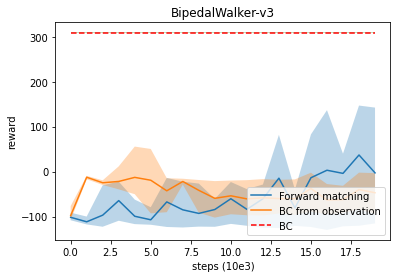

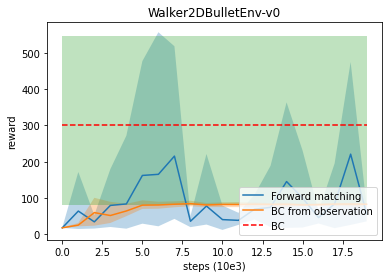

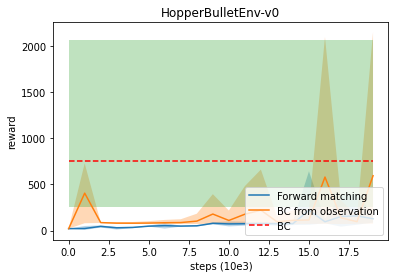

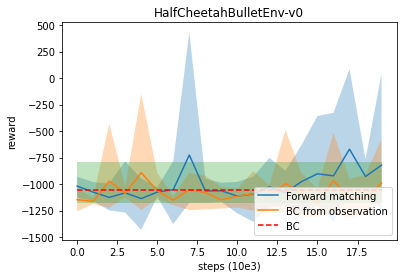

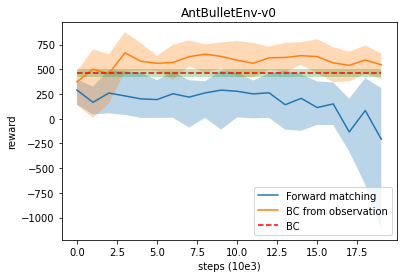

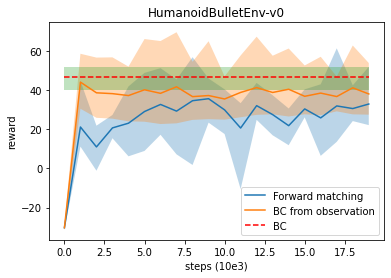

In [9]:
import glob 
def plot_multiple_runs(forward_folder, bco_folder, bc_folder, env_names=None):
    for env in env_names:
        fig, ax = plt.subplots()

        forward_files = glob.glob(forward_folder+env+"*")
        bco_files = glob.glob(bco_folder+env+"*")
        bc_files = glob.glob(bc_folder+env+"*")
        
        forward_trajs = []
        bco_trajs = []
        bc_trajs = []
        
        #### plot forward matching 
        for forward_f in forward_files:
            with open(forward_f) as f:
                rewards = f.read().splitlines()[:20]
                forward_trajs.append(rewards)
        
        forward_trajs = np.array(forward_trajs).astype(float)

        forward_mean = np.mean(forward_trajs, axis=0)
        forward_max = np.max(forward_trajs, axis=0)
        forward_min = np.min(forward_trajs, axis=0)
        x = np.linspace(0, len(rewards)-1, num=len(rewards))

        ax.plot(forward_mean)
        ax.fill_between(x, forward_max, forward_min, alpha=0.3)
        
        
        #### plot bco matching 
        for bco_f in bco_files:
            with open(bco_f) as f:
                rewards = np.array(f.read().splitlines()).astype(float).flatten()[:20]
                bco_trajs.append(rewards)
                
        bco_trajs = np.array(bco_trajs).astype(float)
        bco_mean = np.mean(bco_trajs, axis=0)
        bco_max = np.max(bco_trajs, axis=0)
        bco_min = np.min(bco_trajs, axis=0)
        x = np.linspace(0, len(rewards)-1, num=len(rewards))

        ax.plot(bco_mean)
        ax.fill_between(x, bco_max, bco_min, alpha=0.3)
        
        #### plot bc matching 
        for bc_f in bc_files:
            with open(bc_f) as f:
                rewards = np.array(f.read().splitlines()).astype(float).flatten()[1:]
                bco_trajs = [np.mean(rewards), np.var(rewards)]
                
                bc_mean = np.array([np.mean(rewards) for i in range(20)])

                bc_max = np.array([np.max(rewards) for i in range(20)])
                bc_min = np.array([np.min(rewards) for i in range(20)])
                plt.plot(bc_mean, 'r--') 
                x = np.linspace(0, 19, num=20)
                ax.fill_between(x, bc_max, bc_min, alpha=0.3)

        ax.set_title(env)
        ax.set_xlabel('steps (10e3)')
        ax.set_ylabel('reward')
        ax.legend(["Forward matching", "BC from observation", "BC"], loc ="lower right")
        fig.show()
                                   
env_list = ["BipedalWalker-v3", "Walker2DBulletEnv-v0", "HopperBulletEnv-v0", "HalfCheetahBulletEnv-v0", "AntBulletEnv-v0", "HumanoidBulletEnv-v0"]                          
plot_multiple_runs("records/forward/", "records/bco/", "records/bc/",env_list )

/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: M

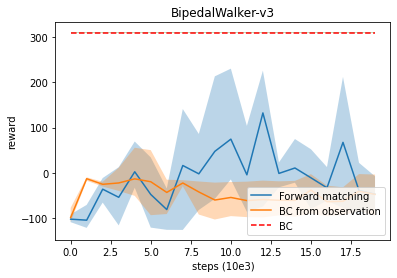

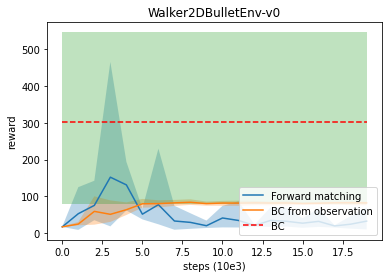

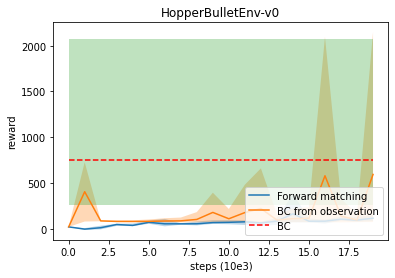

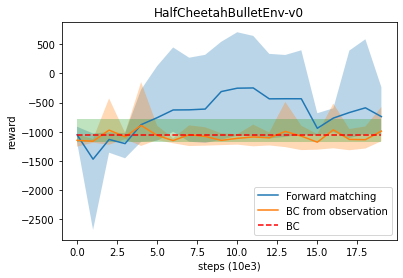

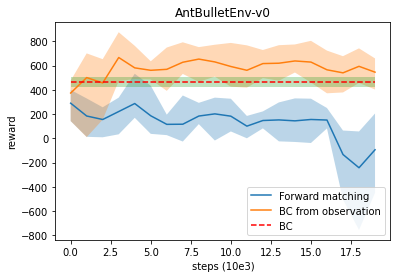

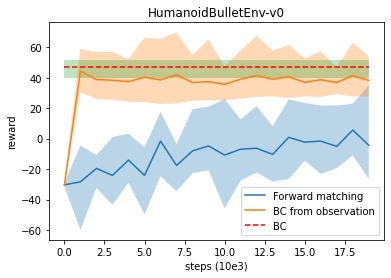

In [59]:
plot_multiple_runs("records/gaussian_policy_gaussian_env/", "records/bco/", "records/bc/",env_list )

/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/user/anaconda3/envs/pwil/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: M

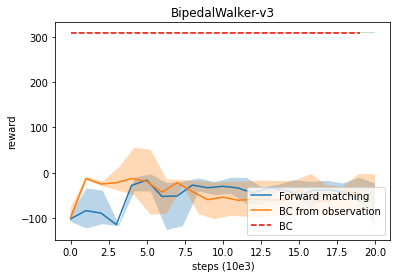

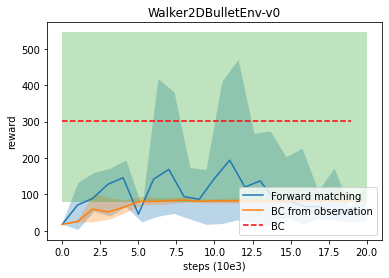

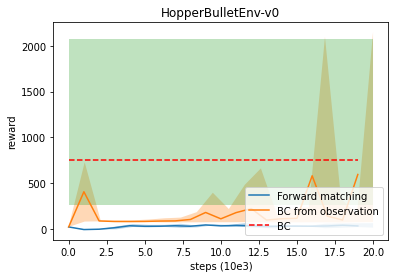

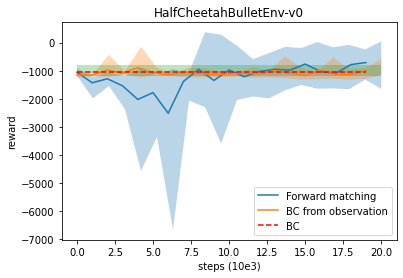

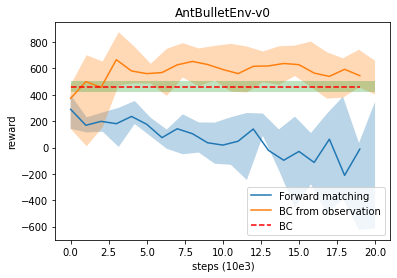

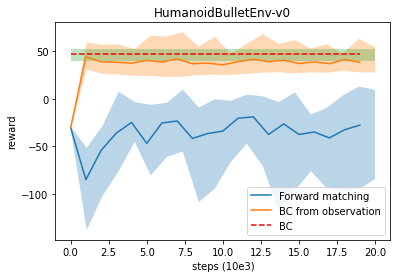

In [54]:
plot_multiple_runs("records/mdn_poicy_gaussian_env/", "records/bco/", "records/bc/",env_list )

In [55]:
# bipedal walker
[-80.71431939543506, -107.64788803287502, 46.10971254079241, 73.32555483257023, -44.20981564636499, 121.81057550628948, 1.4396739966325498, 116.41870502131607, 23.94124108966433, 98.80370937478375, 46.21050926431498, 68.92547245199984, 72.60305584580723, 43.11382392539668, -19.15160680306695, 63.967338609014675, 41.47164657563946, -0.12702182598236209, 7.8780907695502895, 45.37928585095369]

[-80.71431939543506,
 -107.64788803287502,
 46.10971254079241,
 73.32555483257023,
 -44.20981564636499,
 121.81057550628948,
 1.4396739966325498,
 116.41870502131607,
 23.94124108966433,
 98.80370937478375,
 46.21050926431498,
 68.92547245199984,
 72.60305584580723,
 43.11382392539668,
 -19.15160680306695,
 63.967338609014675,
 41.47164657563946,
 -0.12702182598236209,
 7.8780907695502895,
 45.37928585095369]

In [ ]:
"""
[-1373.2022003799393, -1537.3849441439165, -1566.3893398222672, -1566.4634060174883, -1513.6554054038406, -1526.7649856726032, -1588.8617726247337, -1493.9276560460264, -1486.5689613453014, -1550.5739168169828, -1550.2711365015564, -1575.905552052223, -1533.292399915575, -1515.0198687160193, -1549.5659183686507, -1450.3833646696814, -1439.0032680973789, -1505.3988276566417, -1491.981697066, -1451.7861920043692]


[-77.42269800045648, -120.29086165266833, -65.97568645354733, -17.24457595621989, 17.761656451816577, -23.315276349945528, -125.68498414493897, 32.16795578633858, 27.353653848985825, -100.18606084116595, -9.982470982930854, -71.04823052779166, -31.26627925078696, -30.3749177017662, -18.479886873909912, -8.814653659052217, 53.806495660831025, 59.48446484370838, -96.95677284185486, 32.37978991513198]


[17.05794454679845, -1.152118400453911, 73.31450239102124, 43.82633083314189, 45.05796391713242, 40.80798365452466, 19.01886243725472, 35.60101467668996, 19.582562413734195, 42.536604598793204, 47.87169106576544, 19.599122156608583, 39.00406759191564, 78.15280722142549, 76.47825263079336, 28.527372805199242, 20.286506336651456, 82.01481704865347, 26.696482407852393, 17.68209225587311]


[20.340960391015876, -7.5957462968471665, -5.64952268313829, 39.17338988423048, 34.17768875810082, 105.5906503018052, 58.99896630055687, 70.56245956803333, 45.69051809440425, 110.42888658674603, 131.70598534916468, 75.33278338056694, 76.858474227848, 233.44472073642584, 231.76878421835434, 115.70124689468126, 225.17604362895835, 100.70042132769284, 45.59691453532076, 158.23814460606152]


[-584.6469779468895, -790.1563856982439, -738.3381516537241, -303.06726756870256, 51.336031873359694, -558.3819529517864, -705.0943268275055, -232.6737508441126, -686.7766340204014, -724.4446733457228, -568.8822996880676, -774.1916697368074, -628.9576601929583, -641.522208993676, -737.9679958551051, -522.7748998468383, -761.5455540991205, -810.5939675764698, -730.5554652859933, -424.63264384175324]


[99.31250812622015, 110.30787982852996, 154.36258293253405, 196.4705833228953, 219.81495326495863, 81.4895250369373, -73.91483945067316, -4.549355839342006, -459.2008512168189, -125.78358223159816, -216.31058123705515, -58.68871890729858, -264.86666464125386, -1481.982335698971, -2769.588672446682, -888.5039450961544, -940.2829805759836, -1274.6549564888778, -752.758337622611, -658.1891863229729]


[-31.129122906622463, -70.2628989337789, -94.79358454540414, -23.01149874768736, -22.04257649423564, -24.244113261252757, -27.818875505115006, -43.40152464929519, -27.349353352093015, -35.530143053229, -54.14535895695569, -19.235037690635433, -45.05351322031206, -25.952533264753992, -45.002882376082226, -21.464234956854877, -22.752502099574624, 3.393028267252964, -56.258879656719834, -79.67432940683796]
"""

""" mdn + mdn (dynamic + policy)
[-91.97775855422408, -91.48796139516975, -47.35232828546524, -43.96527052342228, -117.21148234120841, -14.893711893999406, -22.249125178151544, -6.492524863067938, -10.193609049387023, -36.36159609961613, -123.98560553134355, -56.422989769197855, -115.31864565200515, 26.53181756763592, -119.69346890627985, -17.30584860213615, -3.4579364564183166, -8.329585256825624, -97.10870243823199, -101.26250989913173]


[17.417215208077085, 11.395020125210742, 17.342992106105235, 17.035776985724297, 11.683159599286592, 38.01104715653452, 177.48464565415205, 26.851959021881598, 51.66713792707914, 3.38634460641906, 0.5635360319310696, 9.774039259614568, 17.175692277298307, 32.18595158152002, 17.77311242160699, 60.77676829090131, 39.33163717346518, 20.450568798254427, 38.63136499542219, 26.327378382157573]


[19.98300957377647, 13.760008000430602, 9.70041215488733, 16.865292796658952, 13.57311732530062, 59.198057405078835, 59.890139134472705, 62.21831534714681, 31.63059420921927, 38.15061728432133, 27.726525388343127, 0.3052555517162763, 24.101196499964892, 27.171015969993253, 41.58941517495393, 7.013132369164583, 8.863949039826178, 5.189351213288767, 18.97373539300934, 42.76350615268128]


[-607.0543385673287, -806.4580132064702, -706.9388296694813, -704.0868158508686, -854.8355523125322, -495.4331999439704, -465.9610431312168, -912.1594922921411, -708.5099486672142, -911.8392636016562, -1027.8732196732442, -998.3502355247043, -1215.182292635422, -590.4106673332353, -239.19080561896124, -455.50458913759735, -737.5466495914256, 339.8731203235975, 332.31882261535577, 116.15955559290299]


[166.49978373269627, 194.79353707459657, 9.34236894216443, -43.54585778075855, 12.830168123697518, -70.88584568151924, -124.73652304496639, -1426.7664706635028, -1214.0157128612082, -743.2890149971461, -1074.9683651205933, -1205.4461384180536, -1184.8804299489884, -1113.642737652988, -763.8236848112497, -727.6740872159183, -567.5114595250955, -253.83123664118088, -157.36145382303067, -627.0726486051612]


[-31.24164405269406, -80.74274846982719, -42.52495495778028, -15.498939063731273, -53.60286526966865, -71.91186545845049, -19.914671887012624, -30.555686888870962, -37.57695954431116, -8.791994321518787, -14.27225190059264, -4.557804993246706, -23.2121430505511, -23.864069365425404, -4.901172084530374, -5.802280785444951, 0.5387475304617476, 4.313701621168237, 5.540979307335364, 1.048698961362165]
"""

In [ ]:
#"""
test_bipedalwalker = [-77.42269800045648, -120.29086165266833, -65.97568645354733, -17.24457595621989, 17.761656451816577, -23.315276349945528, -125.68498414493897, 32.16795578633858, 27.353653848985825, -100.18606084116595, -9.982470982930854, -71.04823052779166, -31.26627925078696, -30.3749177017662, -18.479886873909912, -8.814653659052217, 53.806495660831025, 59.48446484370838, -96.95677284185486, 32.37978991513198]
test_walker = [-1241.2286926378722, -1160.2450865632702, -1302.5257279430775, -1321.1742109382649, -1188.933183313903, -705.0222037711366, -1015.6534497409206, -1223.086064483041, -581.1125714915169, -1094.4109430023177, -1263.2555011234258, 606.2516319491602, 347.13141169409215, 421.8291469984875, -1162.114098068984, -1182.7265993365133, -1263.46067056635, 426.85376063362065, 654.2950759629778, 200.48967327397975, 89.62557959415612, 770.944369011869]
test_hopper = [19.39352412420114, 32.04291391761344, 71.05704872371435, 210.83129950012804, 70.8467080637385, 137.4572230840752, 40.47588962083239, 388.04944066645714, 70.29350711982096, 213.6719275538449, 81.97411059718404, 141.17601595789915, 151.4677262172483, 102.80866475250083, 159.70545355726733, 464.72625602344385, 225.03651377538398, 154.7150833974447, 364.8459397128754, 452.7572393095682]
test_half = [17.013435360947565, 40.15109587138687, 21.430784166587966, 24.17196539273257, 82.36950376110435, 29.22265959028815, 65.57115237712492, 34.345782755340814, 42.59285357176953, 78.61830403883336, 62.88512472101623, 58.8132956755824, 55.83413705380583, 60.73374486486313, 51.154639767290234, 50.608121683934876, 45.42836724520008, 46.15240933758517, 39.74357310803997, 37.22987510561556]
test_ant = [-607.0543385673287, -806.4580132064702, -706.9388296694813, -704.0868158508686, -854.8355523125322, -495.4331999439704, -465.9610431312168, -912.1594922921411, -708.5099486672142, -911.8392636016562, -1027.8732196732442, -998.3502355247043, -1215.182292635422, -590.4106673332353, -239.19080561896124, -455.50458913759735, -737.5466495914256, 339.8731203235975, 332.31882261535577, 116.15955559290299]
test_human = [-31.24164405269406, -80.74274846982719, -42.52495495778028, -15.498939063731273, -53.60286526966865, -71.91186545845049, -19.914671887012624, -30.555686888870962, -37.57695954431116, -8.791994321518787, -14.27225190059264, -4.557804993246706, -23.2121430505511, -23.864069365425404, -4.901172084530374, -5.802280785444951, 10.5387475304617476, 14.313701621168237, 15.540979307335364, 7.048698961362165]

foward_records = [test_bipedalwalker, test_half, test_hopper, test_walker, test_ant, test_human]
#"""

test_bco_bipedal = [-21.622981899611602, -50.45265779702035, -14.964480684141027, -3.974716434900671, -85.41978882118583, -85.41538556643499, -84.24169132222157, -87.91838652590553, -85.30914249103455, -55.75293002613003, -16.839369788537105, -87.10465359533988, -77.72110420887255, -64.78834819576186, -55.42264371588144, -55.08960786631849, -16.98840366882085, -29.061604524564615, -73.68085866489076, -24.15669209049675]

test_bco_walker = [17.05794454679845, -1.152118400453911, 73.31450239102124, 43.82633083314189, 45.05796391713242, 40.80798365452466, 19.01886243725472, 35.60101467668996, 19.582562413734195, 42.536604598793204, 47.87169106576544, 19.599122156608583, 39.00406759191564, 78.15280722142549, 76.47825263079336, 28.527372805199242, 20.286506336651456, 82.01481704865347, 26.696482407852393, 17.68209225587311]

test_bco_hopper = [20.340960391015876, -7.5957462968471665, -5.64952268313829, 39.17338988423048, 34.17768875810082, 105.5906503018052, 58.99896630055687, 70.56245956803333, 45.69051809440425, 110.42888658674603, 131.70598534916468, 75.33278338056694, 76.858474227848, 233.44472073642584, 231.76878421835434, 115.70124689468126, 225.17604362895835, 100.70042132769284, 45.59691453532076, 158.23814460606152]

test_bco_half = [-584.6469779468895, -790.1563856982439, -738.3381516537241, -303.06726756870256, 51.336031873359694, -558.3819529517864, -705.0943268275055, -232.6737508441126, -686.7766340204014, -724.4446733457228, -568.8822996880676, -774.1916697368074, -628.9576601929583, -641.522208993676, -737.9679958551051, -522.7748998468383, -761.5455540991205, -810.5939675764698, -730.5554652859933, -424.63264384175324]

test_bco_ant = [99.31250812622015, 110.30787982852996, 154.36258293253405, 196.4705833228953, 219.81495326495863, 81.4895250369373, -73.91483945067316, -4.549355839342006, -459.2008512168189, -125.78358223159816, -216.31058123705515, -58.68871890729858, -264.86666464125386, -1481.982335698971, -2769.588672446682, -888.5039450961544, -940.2829805759836, -1274.6549564888778, -752.758337622611, -658.1891863229729]

test_bco_human = [-31.129122906622463, -70.2628989337789, -94.79358454540414, -23.01149874768736, -22.04257649423564, -24.244113261252757, -27.818875505115006, -43.40152464929519, -27.349353352093015, -35.530143053229, -54.14535895695569, -19.235037690635433, -45.05351322031206, -25.952533264753992, -45.002882376082226, -21.464234956854877, -22.752502099574624, 3.393028267252964, -56.258879656719834, -79.67432940683796]

bco_records = [test_bco_bipedal,test_bco_walker,test_bco_hopper,test_bco_half,test_bco_ant,test_bco_human]

env_list = ["Pendulum-v0", "BipedalWalker-v3", "Walker2DBulletEnv-v0", "HopperBulletEnv-v0", "HalfCheetahBulletEnv-v0", "AntBulletEnv-v0", "HumanoidBulletEnv-v0"]


In [ ]:

for r in range(len(foward_records)):
    plot_simple_bco(foward_records[r], bco_records[r], env_list[r+1])

In [ ]:
(np.random.rand(ypoints[1:].shape[0])-0.7)*200

In [ ]:
plot_simple_bco(test_pendulum, test_pendulum_f)

In [ ]:
plot_simple_bco(test_walker, test_pendulum_f, s=30)

In [ ]:
plot_simple_bco(test_half, test_pendulum_f, s=10)

In [ ]:
plot_simple_bco(test_bipedalwalker, test_pendulum_f, s=10, off=0.3)